## Differentiating users based on their onchain interactions

We will take all wallets who have interacted with a given contract address, and see if we can add "features" to spot different clusters of wallets. A feature is just some characteristic/variable, such as if a wallet has an ENS domain registered or not.

This can be done in four steps:
1. Write a query on Dune where the returned data has columns for each feature and rows for each wallet 
2. Add parameters for "contract_address", "blockchain", "month", and "minimum calls"
3. Use the dune-client to pull the data for Opensea in September 2023 versus September 2022
4. Use scikit-learn and pandas to cluster the data (PCA + k-means)

I've already [written the query here](https://dune.com/queries/3070841):

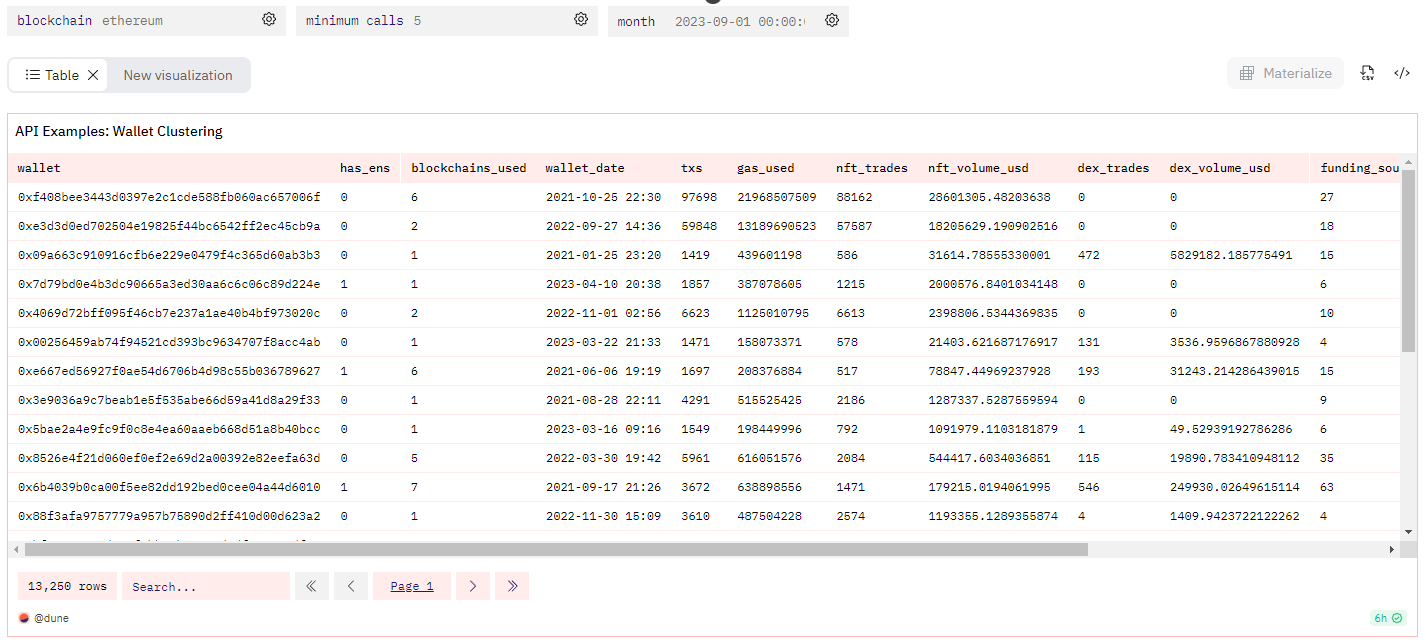

This query uses the following data sources:
- ENS spell
- dex.trades and nft.trades
- CEX address labels
- Raw transactions

## Pulling the data from the API

Let's run the query for Opensea seaport, grabbing wallets that called Seaport on Ethereum at least five transactions during the month of September 2021 - the height of the bull market.

In [60]:
import warnings
warnings.filterwarnings("ignore")

from dune_client.types import QueryParameter
from dune_client.client import DuneClient
from dune_client.query import QueryBase

from dotenv import load_dotenv
import pandas as pd
import numpy as np

#you should use a .env file for your api key
load_dotenv()
dune = DuneClient.from_env()

#putting in our parameters
query = QueryBase(
    query_id=3070841,
    params=[
        QueryParameter.text_type(name="blockchain", value="ethereum"),
        QueryParameter.number_type(name="minimum calls", value=5),
        QueryParameter.date_type(name="month", value="2021-09-01 00:00:00"),
    ],
)

dune = DuneClient.from_env()
# results = dune.run_query(query) #does a fresh run of the query, default is on medium engine.

results = dune.get_latest_result(query, max_age_hours=8) #use this to get results from the last run, instead of re-running it
query_result = pd.DataFrame(results.result.rows)
query_result.head(1)

,blockchains_used,dex_trades,dex_volume_usd,first_tx_date,first_tx_days_ago,funding_sources,gas_used,has_ens,last_tx_date,last_tx_days_ago,nft_trades,nft_volume_usd,times_called,times_cex_funded,times_funded,txs,wallet
0,2.0,24.0,52705.860842,2021-03-14 19:01:07.000 UTC,933.0,18.0,903273880.0,1.0,2023-07-14 00:32:47.000 UTC,82.0,1962.0,459314.455905,1761,3.0,64.0,5158.0,0x5e070c24af683ef391e93bc161ffb6d2326843b5


You can see the features (columns) we're working with below. Hopefully the column names are self explanatory!

In [61]:
query_result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100640 entries, 0 to 100639
Data columns (total 17 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   blockchains_used   100639 non-null  float64
 1   dex_trades         100639 non-null  float64
 2   dex_volume_usd     100639 non-null  float64
 3   first_tx_date      100639 non-null  object 
 4   first_tx_days_ago  100639 non-null  float64
 5   funding_sources    100639 non-null  float64
 6   gas_used           100639 non-null  float64
 7   has_ens            100639 non-null  float64
 8   last_tx_date       100639 non-null  object 
 9   last_tx_days_ago   100639 non-null  float64
 10  nft_trades         100639 non-null  float64
 11  nft_volume_usd     100639 non-null  float64
 12  times_called       100640 non-null  int64  
 13  times_cex_funded   100639 non-null  float64
 14  times_funded       100639 non-null  float64
 15  txs                100639 non-null  float64
 16  wa

It costs 10 credits to run on the medium engine in 1 minute, and costs 1700 credits (1 credit per 1000 datapoints) for the 17x100000 datapoints I will be exporting. You're given 2500 free tier credits.

You can also run it with free tier in app, and then use the get latest results endpoint (which is what I did above).

## Cleaning the Data

Let's get a quick summary of the data to see if we need to remove outliers or apply any transforms.

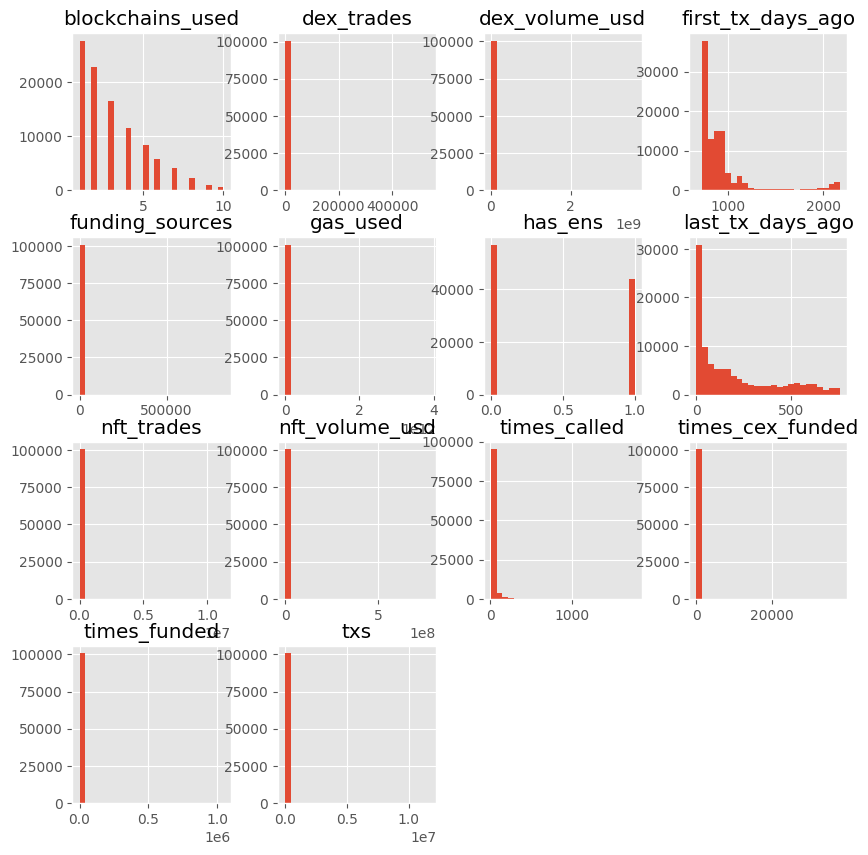

In [62]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.grid(False)
query_result.hist(bins=25, ax=ax)
plt.show()

There are clearly some wild outliers in many of these features, so we will need to take the log transform of some of these values 

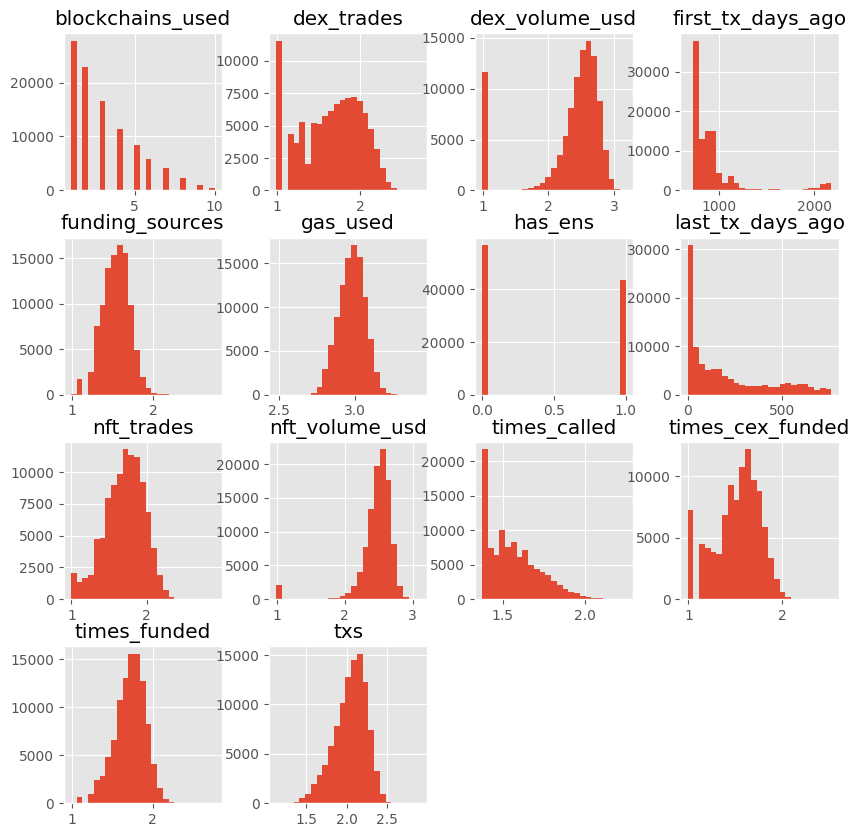

In [66]:
query_result_tf = query_result
query_result_tf.dropna(inplace=True)

log_transform_columns = ['dex_trades', 'dex_volume_usd', 'funding_sources',
       'gas_used', 'nft_trades', 'nft_volume_usd', 'times_called',
       'times_cex_funded', 'times_funded', 'txs']

query_result_tf[log_transform_columns] = query_result_tf[log_transform_columns].applymap(lambda x: np.log1p(x + 1))

#let's plot again
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.grid(False)
query_result.hist(bins=25, ax=ax)
plt.show()

There we go! Now this looks log normal, so we can move on.

## Clustering the wallets

Let's do PCA and Clustering (elbow and stuff)

In [68]:
from sklearn.decomposition import PCA

numerics = ['int64','float64']
df_filtered = query_result_tf.select_dtypes(include=numerics)

print(df_filtered.columns)

pca = PCA()
df_pca = pca.fit_transform(X=df_filtered)
df_pca = pd.DataFrame(df_pca)
df_pca.head()

Index(['blockchains_used', 'dex_trades', 'dex_volume_usd', 'first_tx_days_ago',
       'funding_sources', 'gas_used', 'has_ens', 'last_tx_days_ago',
       'nft_trades', 'nft_volume_usd', 'times_called', 'times_cex_funded',
       'times_funded', 'txs'],
      dtype='object')


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,29.074999,-113.218507,-1.460503,-0.706553,0.316608,-0.323579,-0.349109,0.557032,0.329145,-0.077137,-0.110775,0.084512,-0.027941,0.011345
1,-36.718333,-169.232449,2.603616,-0.831676,0.113697,-0.710597,0.203905,0.398113,0.204288,0.020991,-0.225003,-0.146268,-0.139657,0.050208
2,-122.118337,-187.239773,4.673144,-0.230347,0.364309,-0.526703,0.129957,0.308299,0.348218,-0.138358,-0.107323,-0.058422,0.047608,0.011346
3,-86.395260,-216.289503,4.527940,-0.544026,0.085129,-0.391434,-0.100683,0.306673,0.249907,-0.078235,-0.182259,-0.096930,0.003179,0.027991
4,-97.769637,-234.243195,0.525794,-0.964030,-0.040766,-0.338474,0.127462,0.421776,0.050750,-0.364272,-0.121972,0.031030,0.082504,0.002490


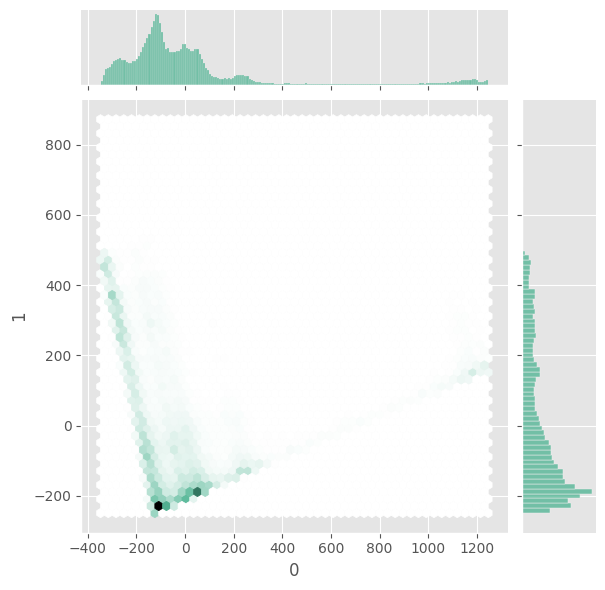

In [69]:
import seaborn as sns

sns.jointplot(x=df_pca[0], y=df_pca[1], kind="hex", color="#4CB391")

We can kind of see a few clusters appearing, but let's use k-means to delineate them better.

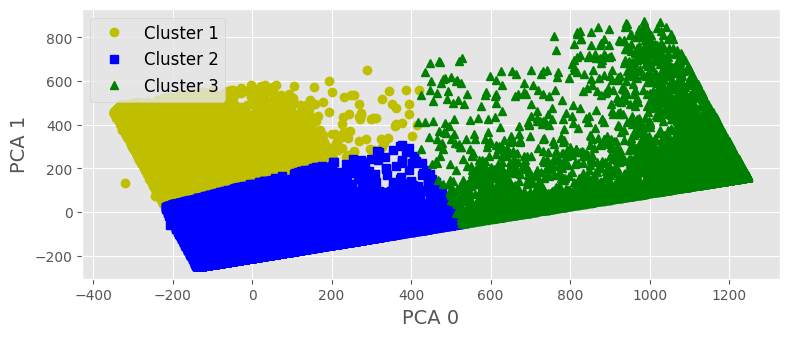

In [70]:
import numpy as np
import os
import pdb

# to make this notebook's output stable across runs
np.random.seed(42)

'''unsupervised classifiers'''
from sklearn.cluster import KMeans
k = 3
kmeans = KMeans(n_clusters=k)
y_pred = kmeans.fit_predict(df_pca)
plt.figure(figsize=(9, 3.5))
plt.plot(df_pca.loc[y_pred==0, 0], df_pca.loc[y_pred==0, 1], "yo", label="Cluster 1")
plt.plot(df_pca.loc[y_pred==1, 0], df_pca.loc[y_pred==1, 1], "bs", label="Cluster 2")
plt.plot(df_pca.loc[y_pred==2, 0], df_pca.loc[y_pred==2, 1], "g^", label="Cluster 3")
plt.xlabel("PCA 0", fontsize=14)
plt.ylabel("PCA 1", fontsize=14)
plt.legend(loc="upper left", fontsize=12)
plt.show()

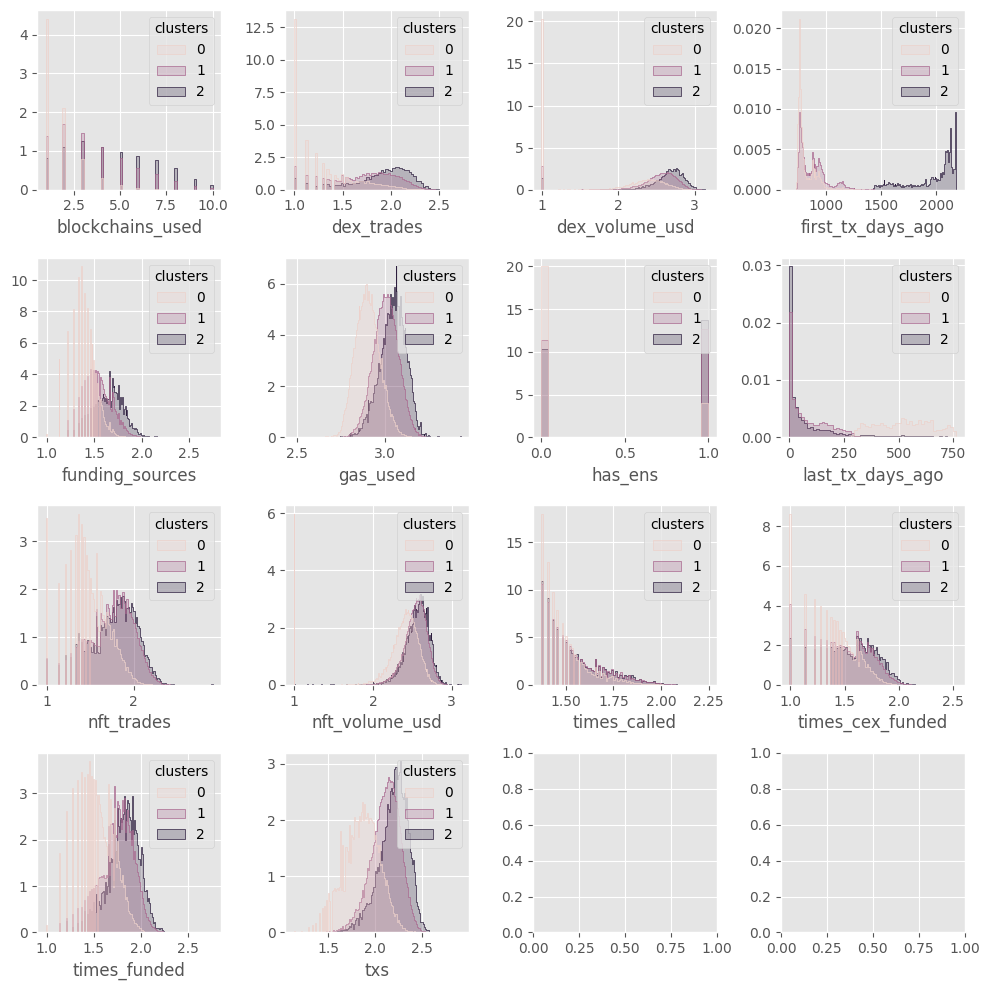

In [71]:
df_filtered["clusters"] = y_pred

fig, ax = plt.subplots(4, 4, figsize=(10, 10))

x=0
y=0
for idx, column in enumerate(df_filtered.columns[:-1]):
    # print(idx, column)
    # print(x,y)
    sns.histplot(
        df_filtered, x=column, hue="clusters", element="step",
        stat="density", common_norm=False, ax = ax[x,y]
    )
    # ax[x,y].set_title(column,fontweight="bold", size=10)
    ax[x,y].set_ylabel('')
    if y == 3:
        y = 0
        x+=1
    else:
        y+=1
        
plt.tight_layout()
plt.show()

From this, I can see that `wallet_days_age` and `times_cex_funded` have the cleanest variance between clusters. It honestly just looks like a segmentation of active versus inactive users, and there is no further behavioral segmentation passed that.

## What comes next?

Go add fork the query and add more features, change the contracts, change the number of clusters, etc.

Have fun, and please reach out if you have any questions :)